## **Import Libraries**

In [2]:
import torch.nn as nn  # Importing neural network module from PyTorch
import torch.optim as optim  # Importing optimization module from PyTorch
from torch.nn import functional as F  # Importing functional API from PyTorch for neural network operations
from torch.utils.data import DataLoader, random_split  # Importing data loading utilities from PyTorch
import pytorch_lightning as pl  # Importing PyTorch Lightning for simplified training
import torchvision.transforms as transforms  # Importing transformation utilities from torchvision
import torchvision.datasets as datasets  # Importing standard datasets from torchvision
import os  # Importing operating system related functionalities
import torch  # Importing PyTorch library
import wandb  # Importing Weights & Biases library for experiment tracking
import random  # Importing random number generation utilities
import numpy as np  # Importing NumPy library for numerical operations
import matplotlib.pyplot as plt # Importing pyplot for ploting grid of images 


In [9]:
torch.manual_seed(2)  # Setting the random seed for PyTorch operations to ensure reproducibility
random.seed(2)  # Setting the random seed for Python's built-in random module
np.random.seed(2)  # Setting the random seed for NumPy operations

## **CHECK DEVICE [CPU/ GPU]**

In [10]:
# Function to determine and set the device for computation (CPU/GPU)
def set_device():
    device = "cpu"  # Defaulting to CPU
    if torch.cuda.is_available():  # Checking if GPU is available
        device = torch.device("cuda")  # Setting device to GPU if available
    else:
        device = torch.device("cpu")  # Otherwise, default to CPU
    return device

device = set_device()  # Calling the function to set the device
print("Currently Using :: ", device)  # Printing the currently used device

Currently Using ::  cuda


In [4]:
# login key for wandb
!wandb login 57566fbb0e091de2e298a4320d872f9a2b200d12

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **Load Data**

In [5]:
def load_data(batch_size, img_size, augmentation = "No"):
    """
    Function to appropriately load data.

    Args:
    - batch_size (int): Batch size for data loaders.
    - img_size (int): Size of the images after resizing.
    - augmentation (str): Whether to apply data augmentation ("Yes" or "No").

    Returns:
    - labels (list): List of class labels.
    - train_loader (DataLoader): DataLoader for training dataset.
    - val_loader (DataLoader): DataLoader for validation dataset.
    - test_loader (DataLoader): DataLoader for test dataset.
    """

    # Define transformations based on augmentation choice
    if augmentation == "Yes":
        train_augmentation = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
        ])
    elif augmentation == "No":
        train_augmentation = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    test_augmentation = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    # Load the dataset
    data_path = "/kaggle/input/naturedataset/inaturalist_12K"  # Path to the dataset directory
    train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_augmentation)
    test_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=test_augmentation)

    # Splitting the train dataset into train and validation sets
    split_ratio = 0.2  # Ratio of validation set to train set
    len_train_data = int(np.ceil(len(train_dataset) * (1 - split_ratio)))  # Length of training data
    len_val_data = int(len(train_dataset) - len_train_data)  # Length of validation data
    labels = train_dataset.classes  # Extracting class labels

    trainset, valset = random_split(train_dataset, [len_train_data, len_val_data])  # Splitting the dataset

    # Creating DataLoaders for train, validation, and test sets
    train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=2, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batch_size, num_workers=2, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

    return labels, train_loader, val_loader, test_loader


## **Class ConvolutionalNeuralNetwork**

In [6]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, PARAM) -> None:
        super().__init__()
        self.flatten = nn.Flatten()  # Flatten layer to convert 2D input to 1D
        self.filter_org = PARAM["filter_org"]  # Organization pattern for number of filters
        self.filter_num = PARAM["filter_num"]  # Number of initial filters
        self.activation = PARAM["activation"]  # Activation function for layers
        self.con_layers = PARAM["con_layers"]  # Number of convolutional layers (default :: 5)
        self.den_layers = PARAM["dense_layers"]  # Number of dense layers 
        self.input_channel = PARAM["input_channel"]  # Number of input channels
        self.filter_num_list = self.organize_filters(self.filter_org, self.filter_num, self.con_layers)  # List of filter numbers for each layer
        self.filter_size_list = PARAM["filter_size"]  # List of filter sizes for each layer
        self.act = self.activation_fun(PARAM["activation"])  # Activation function
        self.output_act = self.activation_fun(PARAM["output_activation"])  # Activation function for output layer
        self.padding = PARAM["padding"]  # Padding size for convolutional layers
        self.stride = PARAM["stride"]  # Stride size for convolutional layers
        self.pool_padding = PARAM["pool_padding"]  # Padding size for pooling layers
        self.pool_stride = PARAM["pool_stride"]  # Stride size for pooling layers
        self.dense_output_list = PARAM["dense_output_list"]  # List of output sizes for dense layers
        self.image_size = PARAM["image_size"]  # Input image size
        self.pool_filter_size = PARAM["pool_filter_size"]  # Filter size for pooling layers
        self.dropout_list = PARAM["dropout"]  # List of dropout probabilities for layers
        self.batch_norm = PARAM["batch_norm"]  # Whether to use batch normalization (Choices : Yes / No)
        self.initialize = PARAM["init"]  # Weight initialization method (Choices : random/Xavior)

        # Creating the structure of CNN 
        self.create_con_layers(self.input_channel, self.filter_size_list, self.dense_output_list, self.filter_num_list, self.act, self.pool_filter_size, self.output_act, self.image_size, self.dropout_list)


    def create_con_layers(self, input_channel, filter_size_list, dense_output_list, filter_num_list, act, pool_filter_size, output_act, image_size, dropout_list):
        """
        Method to create convolutional and dense layers.

        Args:
        - input_channel (int): Number of input channels.
        - filter_size_list (list): List of filter sizes for convolutional layers.
        - dense_output_list (list): List of output sizes for dense layers.
        - filter_num_list (list): List of numbers of filters for convolutional layers.
        - act (nn.Module): Activation function for layers.
        - pool_filter_size (int): Filter size for pooling layers.
        - output_act (nn.Module): Activation function for output layer.
        - image_size (int): Input image size.
        - dropout_list (list): List of dropout probabilities for layers.
        """
        self.layers = nn.ModuleList()  # List to store layers
        computations = 0 # Counter for the Computations

        # Convolutional layers
        for i in range(1, self.con_layers+1):
            # Creating convolutional layer followed by activation function and max pooling
            layer = nn.Sequential(nn.Conv2d(input_channel, filter_num_list[i-1], filter_size_list[i-1], padding=self.padding, stride=self.stride, bias=False), act, nn.MaxPool2d(pool_filter_size, padding=self.pool_padding, stride=self.pool_stride))
            
            # Updating image size after convolution and pooling
            image_size = (image_size - filter_size_list[i-1] + 2 * self.padding) // self.stride + 1

            # Add Computations for the current Layer
            computations = computations + ((filter_size_list[i-1] ** 2) * input_channel * (image_size ** 2) * filter_num_list[i-1] + filter_num_list[i-1])

            #update image size after pooling layer
            image_size = (image_size + 2 * self.pool_padding - (1 * (pool_filter_size - 1)) - 1) // self.pool_stride + 1

            input_channel = filter_num_list[i-1]  # Updating input channel for next layer
            self.layers.append(layer)  # Adding layer to the list

        dense_input = filter_num_list[self.con_layers-1] * (image_size ** 2)  # Calculating input size for dense layers
        
        # Dense layers
        for i in range(1, self.den_layers+1):
            # Creating dense layer followed by convolutional layer
            layer = nn.Sequential(nn.Linear(dense_input, dense_output_list[i-1]), act)

            # Add Computations for the current Layer
            computations = computations + (dense_input + 1) * dense_output_list[i-1]

            dense_input = dense_output_list[i-1]  # Updating input size for next layer
            self.layers.append(layer)  # Adding layer to the list
            
        # Output layer
        layer = nn.Sequential(nn.Linear(dense_input, 10), nn.Softmax(dim=1))

        # Add Computations for the current Layer
        computations = computations + (dense_input + 1) * 10

        self.layers.append(layer)  # Adding output layer to the list

        print("Computation :: ", computations)  # Printing total computation required

        # Initialization, batch normalization, and dropout
        for layer in range(self.con_layers + self.den_layers + 1):
            if self.initialize == "Xavier" and isinstance(self.layers[layer], nn.Conv2d):
                nn.init.xavier_uniform_(self.layers[layer].weight)
            if self.batch_norm == "Yes" and layer < self.con_layers:
                self.layers[layer].insert(1, nn.BatchNorm2d(filter_num_list[layer]))
            if (layer < self.con_layers + self.den_layers) and self.dropout_list[layer] != 0:
                self.layers[layer].append(nn.Dropout(dropout_list[layer]))

    def organize_filters(self, filter_org, filter_number, layers):
        """
        Method to organize filter numbers for convolutional layers.

        Args:
        - filter_org (str): Organization pattern for filter numbers.
        - filter_number (int): Number of initial filters.
        - layers (int): Number of convolutional layers.

        Returns:
        - filter_num (list): List of filter numbers for each layer.
        """
        if filter_org == "same":
            filter_num = [filter_number] * layers
        elif filter_org == "double":
            filter_num = [filter_number * (2 ** i) for i in range(layers)]
        elif filter_org == "half":
            filter_num = [int(filter_number * (2 ** (-i))) for i in range(layers)]
        elif filter_org == "alternating_list":
            filter_num = [filter_number if i % 2 == 0 else filter_number * 2 for i in range(layers)]
        elif filter_org == "d_alternating_list":
            filter_num = [filter_number if i % 4 == 0 or i % 4 == 1 else filter_number * 2 for i in range(layers)]
        elif filter_org == 'desc':
            filter_num = [filter_number - i for i in range(layers)]
        elif filter_org == "asc":
            filter_num = [filter_number + i for i in range(layers)]
        return filter_num

    def activation_fun(self, act):
        """
        Method to get activation function module.

        Args:
        - act (str): Name of the activation function.

        Returns:
        - act_fun (nn.Module): Activation function module.
        """
        if act == "ReLU":
            act_fun = nn.ReLU()
        elif act == "GELU":
            act_fun = nn.GELU()
        elif act == "SiLU":
            act_fun = nn.SiLU()
        elif act == "Mish":
            act_fun = nn.Mish()
        elif act == "softmax":
            act_fun = nn.Softmax(dim=1)
        elif act == "ELU":
            act_fun = nn.ELU()
        elif act == "LeakyReLU":
            act_fun = nn.LeakyReLU()
        return act_fun

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - x (torch.Tensor): Output tensor.
        """
        for i in range(0, self.con_layers):
            x = self.layers[i](x)  # Pass through convolutional layers
        x = self.flatten(x)  # Flatten the output tensor
        for i in range(0, self.den_layers):
            x = self.layers[i + self.con_layers](x)  # Pass through dense layers
        x = self.layers[self.con_layers + self.den_layers](x)  # Pass through output layer
        return x

    def set_optimizer(self, optimizer_name, learning_rate):
        """
        Method to set the optimizer for the model.

        Args:
        - optimizer_name (str): Name of the optimizer ('SGD', 'Adam', .).
        - learning_rate (float): Learning rate for the optimizer.
        """
        if optimizer_name == 'sgd':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        elif optimizer_name == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer_name == 'rmsprop':
            self.optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)
        elif optimizer_name == "nadam":
            self.optimizer = optim.NAdam(self.parameters(), lr = learning_rate)
        elif optimizer_name == "adagrad":
            self.optimizer = optim.Adagrad(self.parameters(), lr = learning_rate)
        return self.optimizer



### **Setting Parameters** 

In [ ]:
PARAM = {
    "con_layers" : 5,
    "dense_layers" : 1,
    "filter_size" : [3]*5,
    "output_activation" : "softmax", 
    "dense_output_list" : [32],
    "filter_num" : 16,
    "activation" : "Mish",
    "filter_org" : "same",  #double half
    "input_channel" : 3,
    "padding" : 0,
    "stride" : 1,
    "pool_padding" : 0,
    "pool_stride" : 1,
    "image_size" : 256,
    "pool_filter_size" : 3,
    "batch_size" : 32,
    "eta" : 0.0001,
    "dropout" : [0, 0, 0, 0, 0, 0.1],
    "epochs" : 1,
    "augmentation" : "No",
    "batch_norm" : "Yes",
    "init" : "Random",
    "optimizer_name" : "adam"
}

net = ConvolutionalNeuralNetwork(PARAM).to(device)


## **Model Training**

In [7]:
def train_model(model, device, PARAM, console_log, wandb_log, return_model=0):
    """
    Function to train the model.

    Args:
    - model (ConvolutionalNeuralNetwork): The model to be trained.
    - device (torch.device): Device to run the training on (CPU or GPU).
    - PARAM (dict): Dictionary containing training parameters.
    - console_log (int): Flag indicating whether to log training details to the console (1 for yes, 0 for no).
    - wandb_log (int): Flag indicating whether to log training details to wandb (1 for yes, 0 for no).
    - return_model (int): Flag indicating whether to return the trained model (1 for yes, 0 for no).

    Returns:
    - (float or ConvolutionalNeuralNetwork): If return_model is 1, returns the trained model.
                                            Otherwise, returns the validation accuracy.
    """

    # Initialize wandb project and set run name if wandb_log is enabled
    if wandb_log == 1:
        wandb.init(project='DL-Assignment2')
        wandb.run.name = 'RUN-ON-BEST-CONFIG'

    # Set the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = model.set_optimizer(PARAM["optimizer_name"], PARAM["eta"])

    # Load data for training, validation, and testing
    labels, train_loader, val_loader, test_loader = load_data(PARAM["batch_size"], PARAM["image_size"], PARAM["augmentation"])

    # Iterate over epochs
    for epoch in range(PARAM["epochs"]):
        model.train() # Set model to training mode
        # Initialize varibles to 0 for each epochs
        running_loss = 0.0
        correct = 0
        total = 0
        count = 0

        # Training loop
        for images, labels in train_loader: 
            images = images.to(device) # Move image to respective device
            labels = labels.to(device) # Move labels to respective device 
            optimizer.zero_grad()
            outputs = model(images)  # Forward Pass : Compute predicted outputs
            loss = criterion(outputs, labels) # Compute Loss
            loss.backward()  # Backward Pass 
            optimizer.step()  # update parametes 
            running_loss += loss.item()  # Add loss for curr batch to global loss 

            # Calculate training accuracy
            prob, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

#             For Debuging 
#             count += 1
#             if count % 5 == 0:
#                 print(count, end=" | ")
 
        model.eval() # Set model to evalution mode 
        running_val_loss = 0.0 
        correct_pred = 0
        total_pred = 0

        # Validation loop
        with torch.no_grad():
            for val_img, val_label in val_loader:
                # Move images and labels to device
                val_img = val_img.to(device)
                val_label = val_label.to(device)

                # Forward Pass 
                val_output = model(val_img)

                # Calculating Loss 
                loss_val = criterion(val_output, val_label)
                running_val_loss += loss_val.item()

                #Calculation of Correctly Predicted Class
                prob, class_ = torch.max(val_output.data, 1)
                total_pred += val_label.size(0)
                correct_pred += (class_ == val_label).sum().item()

        # Log training details to console
        if console_log == 1:
            print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Training_Accuracy: {100 * correct / total}%, Validation_Loss : {running_val_loss/len(val_loader)}, Validation_accuracy : {100 * correct_pred / total_pred}%")

        # Log training details to wandb
        if wandb_log == 1:
            wandb.log(
                {
                    'epochs': epoch+1,
                    'training_loss': running_loss/len(train_loader),
                    'training_accuracy': 100 * correct / total,
                    'Validation_Loss': running_val_loss/len(val_loader),
                    'Validation_accuracy': 100 * correct_pred / total_pred
                }
            )

        # Finish wandb run
    if wandb_log == 1:
        wandb.log({
                "Accuracy" : 100 * correct_pred / total_pred
            })
        wandb.finish()

    # Return either trained model or validation accuracy based on return_model flag
    if return_model:
        return model
    return 100 * correct_pred / total_pred


In [ ]:
net = train_model(net, device, PARAM, 1, 0, 1)
print(net)

# **Question - 2** 

In [7]:
def fit_model(model, device, PARAM):
    """
    Function to train and validate a given model.

    Args:
        model (torch.nn.Module): The neural network model to train.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
        PARAM (dict): Dictionary containing parameters for training and validation.

    Returns:
        float: Validation accuracy of the trained model.
    """
    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Set up the optimizer
    optimizer = model.set_optimizer(PARAM["optimizer_name"], PARAM["eta"])

    # Load data
    labels, train_loader, val_loader, test_loader = load_data(PARAM["batch_size"], PARAM["image_size"], PARAM["augmentation"])

    # Loop through epochs
    for epoch in range(PARAM["epochs"]):
        model.train() # Set model in training mode
        running_loss = 0.0 # Track of loss for current epochs
        correct = 0 # Counter for correct predictions
        total = 0 # Counter for total images to predict

        # Iterate over training data
        for images, labels in train_loader:
            # Move images, labels to device 
            images = images.to(device)
            labels = labels.to(device)

            # set gradients to zero
            optimizer.zero_grad()

            outputs = model(images) # Forward Pass 
            loss = criterion(outputs, labels) # Calculate Loss 
            loss.backward() # Backward Propogation
            optimizer.step() # Update Gradient
            running_loss += loss.item() # Accumulate Loss  

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval() # Set model in evaluation mode
        running_val_loss = 0.0 # keep track of accumulated loss for single epoch acorss validation data
        correct_pred = 0 # Counter for correctly predicted validation dataset images
        total_pred = 0 # Total Validation images

        with torch.no_grad(): 
            # Iterate over validation data
            for val_img, val_label in val_loader:
                # Move val image, label to device
                val_img = val_img.to(device)
                val_label = val_label.to(device)

                
                val_output = model(val_img) # Forward Pass
                loss_val = criterion(val_output, val_label) # Loss Calculate
                running_val_loss += loss_val.item() # Accumulate loss

                # Calculate for Accuracy
                idx, class_ = torch.max(val_output.data, 1)
                total_pred += val_label.size(0)
                correct_pred += (class_ == val_label).sum().item()

        # Print and log epoch statistics
        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Training_Accuracy: {100 * correct / total}%, Validation_Loss : {running_val_loss/len(val_loader)}, Validation_accuracy : {100 * correct_pred / total_pred}%")
        wandb.log(
            {
                'epochs' : epoch+1,
                'training_loss' : running_loss/len(train_loader),
                'training_accuracy' : 100 * correct / total,
                'Validation_Loss' : running_val_loss/len(val_loader),
                'Validation_accuracy' : 100 * correct_pred / total_pred
            }
        )

    # Return validation accuracy
    return 100 * correct_pred / total_pred

In [7]:
sweep_config = {
            'name': 'Final_Sweep ',
            'method': 'bayes',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters': 
                {
                    'epochs' : {'values': [15]},
                    'batch_size' : {'values': [8, 16]},
                    'learning_rate' : {'values': [0.00003, 0.00001]},
                    'dense_sizes' : {'values': [256, 512]},
                    'activation' : {'values': ['ReLU', 'LeakyReLU', 'SiLU']},
                    'kernel' : {'values' : [64]},
                    'data_augmentation' : {'values' : ["No"]},
                    'kernel_aug' : {'values' : ["same"]},
                    'dropout' : {'values' : [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.3], [0, 0, 0, 0, 0, 0.2]]},
                    'batch_norm' : {'values' : ["Yes"]},
                    'filter_size' : {'values' : [3]},
                    'init' : {'values' : ['random', 'Xavier']},
                }
            }


In [8]:
def train():
    var1 = wandb.init(project="DL-Assignment2")
    var2 = var1.config

    # wandb.run.name = 'Optimizer:- ' + var2.optimizer + ' Epoch:- ' + str(var2.epochs) + " Avtivation_Function :- " + var2.activation + " Batch_Size :- " + str(var2.batch_size) + " Initialization :- " + var2.initialization + \
    #                 ' layers:-' + str(len(var2.hidden_layers)) +' decay:-' + str(var2.weight_decay) + ' beta:-' + str(var2.beta) + ' learning_rate:-' + str(var2.learning_rate) + \
    #                 ' beta2 :- ' + str(var2.beta)
    
    wandb.run.name = (f"epochs:{var2.epochs}_lr:{var2.learning_rate}_batch_size:{var2.batch_size}_filter_size:{var2.filter_size}_act:{var2.activation}_dropout:{var2.dropout}")

    PARAM = {
        "con_layers" : 5,
        "dense_layers" : 1,
        "filter_size" :  [var2.filter_size]* 5,
        "output_activation" : "softmax", 
        "dense_output_list" : [var2.dense_sizes],
        "filter_num" : var2.kernel,
        "activation" : var2.activation,
        "filter_org" : "same", #double half
        "input_channel" : 3,
        "padding" : 1,
        "stride" : 1,
        "pool_padding" : 0,
        "pool_stride" : 2,
        "image_size" : 224,
        "pool_filter_size" : 2,
        "batch_size" : var2.batch_size,
        "eta" : var2.learning_rate,
        "dropout" : var2.dropout,
        "epochs" : var2.epochs,
        "augmentation" : var2.data_augmentation,
        "batch_norm" : var2.batch_norm,
        "init" : var2.init,
        "optimizer_name" : 'adam'
    }

    model = ConvolutionalNeuralNetwork(PARAM).to(device)
    accuracy = fit_model(model, device, PARAM)
    wandb.log({
                "Accuracy" : accuracy
            })
    wandb.finish()


In [9]:
sweep_id = wandb.sweep(sweep_config, project="DL-Assignment2")
wandb.agent(sweep_id, train, count = 20)
wandb.finish()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 1udrap63
Sweep URL: https://wandb.ai/cs23m026/DL-Assignment2/sweeps/1udrap63


wandb: Agent Starting Run: wfj41aa0 with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 256
wandb: 	dropout: [0, 0, 0, 0, 0, 0.2]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: Xavier
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 3e-05
wandb: Currently logged in as: cs23m026. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  701664330
Epoch 3, Training Loss: 2.1397478458881376, Training_Accuracy: 32.475%, Validation_Loss : 2.1478124885559082, Validation_accuracy : 30.815407703851925%
Epoch 4, Training Loss: 2.1170790915489195, Training_Accuracy: 34.325%, Validation_Loss : 2.1270161666870115, Validation_accuracy : 32.716358179089546%
Epoch 5, Training Loss: 2.101128001689911, Training_Accuracy: 36.525%, Validation_Loss : 2.1259148874282836, Validation_accuracy : 33.26663331665833%
Epoch 6, Training Loss: 2.0859104862213136, Training_Accuracy: 37.975%, Validation_Loss : 2.110864863395691, Validation_accuracy : 35.617808904452225%
Epoch 7, Training Loss: 2.0729138534069063, Training_Accuracy: 39.2625%, Validation_Loss : 2.1035074701309204, Validation_accuracy : 35.66783391695848%
Epoch 8, Training Loss: 2.062289619207382, Training_Accuracy: 40.4%, Validation_Loss : 2.106601375579834, Validation_accuracy : 35.01750875437719%
Epoch 9, Training Loss: 2.0502159850597383, Training_Accuracy: 41.925%

wandb: Agent Starting Run: 6eus103a with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 8
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 256
wandb: 	dropout: [0, 0, 0, 0, 0, 0.3]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: Xavier
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  701664330
Epoch 1, Training Loss: 2.2670851430892944, Training_Accuracy: 17.75%, Validation_Loss : 2.2237861170768736, Validation_accuracy : 22.26113056528264%
Epoch 2, Training Loss: 2.215459464430809, Training_Accuracy: 24.2625%, Validation_Loss : 2.1872901639938354, Validation_accuracy : 26.963481740870435%
Epoch 3, Training Loss: 2.189154632806778, Training_Accuracy: 27.0%, Validation_Loss : 2.172259668827057, Validation_accuracy : 30.71535767883942%
Epoch 4, Training Loss: 2.1673549118041993, Training_Accuracy: 29.8125%, Validation_Loss : 2.1592866530418395, Validation_accuracy : 29.864932466233117%
Epoch 5, Training Loss: 2.152208688735962, Training_Accuracy: 31.475%, Validation_Loss : 2.1485260462760927, Validation_accuracy : 30.915457728864432%
Epoch 6, Training Loss: 2.143515688896179, Training_Accuracy: 32.375%, Validation_Loss : 2.1433165059089663, Validation_accuracy : 30.71535767883942%
Epoch 7, Training Loss: 2.1286229997873307, Training_Accuracy: 33.8875%

wandb: Agent Starting Run: bc6p6700 with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0.2]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  702469962
Epoch 1, Training Loss: 2.261861029624939, Training_Accuracy: 18.1625%, Validation_Loss : 2.218544087409973, Validation_accuracy : 24.16208104052026%
Epoch 2, Training Loss: 2.206068953037262, Training_Accuracy: 24.65%, Validation_Loss : 2.1938231658935545, Validation_accuracy : 25.862931465732867%
Epoch 3, Training Loss: 2.177075073480606, Training_Accuracy: 28.75%, Validation_Loss : 2.166296161651611, Validation_accuracy : 29.31465732866433%
Epoch 4, Training Loss: 2.1575486447811127, Training_Accuracy: 31.1375%, Validation_Loss : 2.1501782207489013, Validation_accuracy : 32.66633316658329%
Epoch 5, Training Loss: 2.1418654606342318, Training_Accuracy: 32.9875%, Validation_Loss : 2.13571803855896, Validation_accuracy : 32.61630815407704%
Epoch 6, Training Loss: 2.1289289815425874, Training_Accuracy: 34.3625%, Validation_Loss : 2.1281731729507447, Validation_accuracy : 34.76738369184592%
Epoch 7, Training Loss: 2.1161731066703795, Training_Accuracy: 35.825%, 

wandb: Agent Starting Run: f0sby26l with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0.2]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: Xavier
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 3e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  702469962
Epoch 1, Training Loss: 2.2284714682102202, Training_Accuracy: 22.45%, Validation_Loss : 2.1804122943878173, Validation_accuracy : 29.564782391195596%
Epoch 2, Training Loss: 2.1521765480041504, Training_Accuracy: 31.125%, Validation_Loss : 2.152202238082886, Validation_accuracy : 30.265132566283143%
Epoch 3, Training Loss: 2.1176915616989134, Training_Accuracy: 34.475%, Validation_Loss : 2.116860144615173, Validation_accuracy : 34.667333666833414%
Epoch 4, Training Loss: 2.0921282136440276, Training_Accuracy: 37.2875%, Validation_Loss : 2.1136591987609865, Validation_accuracy : 34.76738369184592%
Epoch 5, Training Loss: 2.07364239025116, Training_Accuracy: 39.3625%, Validation_Loss : 2.1157161598205567, Validation_accuracy : 33.81690845422711%
Epoch 6, Training Loss: 2.0573478791713713, Training_Accuracy: 40.7625%, Validation_Loss : 2.0985590238571166, Validation_accuracy : 35.617808904452225%
Epoch 7, Training Loss: 2.0425685040950774, Training_Accuracy: 42.

wandb: Agent Starting Run: ipz3jktf with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0.3]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  702469962
Epoch 1, Training Loss: 2.2643428144454956, Training_Accuracy: 17.6125%, Validation_Loss : 2.2354185848236083, Validation_accuracy : 20.66033016508254%
Epoch 2, Training Loss: 2.2131650347709657, Training_Accuracy: 24.175%, Validation_Loss : 2.2028416118621825, Validation_accuracy : 26.11305652826413%
Epoch 3, Training Loss: 2.185446918487549, Training_Accuracy: 27.8625%, Validation_Loss : 2.1882112941741942, Validation_accuracy : 26.71335667833917%
Epoch 4, Training Loss: 2.1651308360099795, Training_Accuracy: 29.7875%, Validation_Loss : 2.1777901849746706, Validation_accuracy : 28.064032016008003%
Epoch 5, Training Loss: 2.152843670129776, Training_Accuracy: 31.3%, Validation_Loss : 2.1625930070877075, Validation_accuracy : 29.664832416208103%
Epoch 6, Training Loss: 2.140479171037674, Training_Accuracy: 32.6875%, Validation_Loss : 2.1552788486480714, Validation_accuracy : 31.165582791395696%
Epoch 7, Training Loss: 2.130830528497696, Training_Accuracy: 33.9

wandb: Agent Starting Run: 1macoqx0 with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 8
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0.3]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: Xavier
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 3e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  702469962
Epoch 1, Training Loss: 2.2206033474206923, Training_Accuracy: 22.2625%, Validation_Loss : 2.183529993534088, Validation_accuracy : 26.763381690845424%
Epoch 2, Training Loss: 2.1556549805402754, Training_Accuracy: 30.2875%, Validation_Loss : 2.1274994292259217, Validation_accuracy : 33.01650825412706%
Epoch 3, Training Loss: 2.123426506638527, Training_Accuracy: 33.85%, Validation_Loss : 2.114998945236206, Validation_accuracy : 33.96698349174587%
Epoch 4, Training Loss: 2.102278315663338, Training_Accuracy: 36.0875%, Validation_Loss : 2.0950423974990846, Validation_accuracy : 36.61830915457729%
Epoch 5, Training Loss: 2.083821501135826, Training_Accuracy: 37.6375%, Validation_Loss : 2.0957628297805786, Validation_accuracy : 36.21810905452726%
Epoch 6, Training Loss: 2.07086574780941, Training_Accuracy: 39.425%, Validation_Loss : 2.0963286213874817, Validation_accuracy : 36.818409204602304%
Epoch 7, Training Loss: 2.051713381767273, Training_Accuracy: 41.5125%

wandb: Agent Starting Run: 8tvn8gps with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0.2]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  702469962
Epoch 1, Training Loss: 2.266609194278717, Training_Accuracy: 18.3875%, Validation_Loss : 2.223994245529175, Validation_accuracy : 23.111555777888945%
Epoch 2, Training Loss: 2.2042771384716033, Training_Accuracy: 25.9125%, Validation_Loss : 2.176959324836731, Validation_accuracy : 28.664332166083042%
Epoch 3, Training Loss: 2.1714018075466157, Training_Accuracy: 29.625%, Validation_Loss : 2.1549647855758667, Validation_accuracy : 31.81590795397699%
Epoch 4, Training Loss: 2.149105224132538, Training_Accuracy: 32.4625%, Validation_Loss : 2.139150547981262, Validation_accuracy : 33.26663331665833%
Epoch 5, Training Loss: 2.1318378183841706, Training_Accuracy: 33.975%, Validation_Loss : 2.1321166019439697, Validation_accuracy : 33.71685842921461%
Epoch 6, Training Loss: 2.118638226985931, Training_Accuracy: 35.275%, Validation_Loss : 2.122281030654907, Validation_accuracy : 35.16758379189595%
Epoch 7, Training Loss: 2.1053475794792176, Training_Accuracy: 36.775%

wandb: Agent Starting Run: en6ccgb9 with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 8
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0.2]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  702469962
Epoch 1, Training Loss: 2.2531827825307844, Training_Accuracy: 20.1625%, Validation_Loss : 2.211366729736328, Validation_accuracy : 24.862431215607803%
Epoch 2, Training Loss: 2.1933982269763947, Training_Accuracy: 26.675%, Validation_Loss : 2.1854338517189027, Validation_accuracy : 26.313156578289146%
Epoch 3, Training Loss: 2.1679819849729536, Training_Accuracy: 29.5375%, Validation_Loss : 2.160584682941437, Validation_accuracy : 30.965482741370685%
Epoch 4, Training Loss: 2.146271118402481, Training_Accuracy: 31.9125%, Validation_Loss : 2.1451796875, Validation_accuracy : 31.66583291645823%
Epoch 5, Training Loss: 2.129130380153656, Training_Accuracy: 33.9125%, Validation_Loss : 2.1357463598251343, Validation_accuracy : 32.11605802901451%
Epoch 6, Training Loss: 2.1126499621868136, Training_Accuracy: 35.5125%, Validation_Loss : 2.134802590370178, Validation_accuracy : 33.516758379189596%
Epoch 7, Training Loss: 2.1017172961235047, Training_Accuracy: 36.6875

wandb: Agent Starting Run: 40cizuj9 with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 8
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 256
wandb: 	dropout: [0, 0, 0, 0, 0, 0.2]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 3e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  701664330
Epoch 1, Training Loss: 2.2256016912460326, Training_Accuracy: 22.65%, Validation_Loss : 2.172516248703003, Validation_accuracy : 28.714357178589296%
Epoch 2, Training Loss: 2.1569598479270935, Training_Accuracy: 30.4625%, Validation_Loss : 2.150448637008667, Validation_accuracy : 31.115557778889446%
Epoch 3, Training Loss: 2.1271762851476668, Training_Accuracy: 33.55%, Validation_Loss : 2.1286523451805115, Validation_accuracy : 33.26663331665833%
Epoch 4, Training Loss: 2.1014664548635484, Training_Accuracy: 36.0625%, Validation_Loss : 2.121898434638977, Validation_accuracy : 33.91695847923962%
Epoch 5, Training Loss: 2.0924372819662094, Training_Accuracy: 37.025%, Validation_Loss : 2.1104975543022158, Validation_accuracy : 35.36768384192096%
Epoch 6, Training Loss: 2.0703989660739897, Training_Accuracy: 39.625%, Validation_Loss : 2.1056954288482665, Validation_accuracy : 35.06753376688344%
Epoch 7, Training Loss: 2.055148220062256, Training_Accuracy: 41.05%,

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [31]:
wandb.finish()

In [9]:
best_sweep_config = {
            'name': 'Sweep-Best-Config ',
            'method': 'bayes',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters': 
                {
                    'epochs' : {'values': [30]},
                    'batch_size' : {'values': [32]},
                    'learning_rate' : {'values': [0.0001]},
                    'dense_sizes' : {'values': [256]},
                    'activation' : {'values': ['ReLU']},
                    'kernel' : {'values' : [64]},
                    'data_augmentation' : {'values' : ["No"]},
                    'kernel_aug' : {'values' : ["same"]},
                    'dropout' : {'values' : [[0, 0, 0, 0, 0, 0.3]]},
                    'batch_norm' : {'values' : ["Yes"]},
                    'filter_size' : {'values' : [3]},
                    'init' : {'values' : ['random']},
                }
            }

In [11]:
sweep_id = wandb.sweep(best_sweep_config, project="DL-Assignment2")
wandb.agent(sweep_id, train, count = 1)
wandb.finish()

Create sweep with ID: 07nbybnw
Sweep URL: https://wandb.ai/cs23m026/DL-Assignment2/sweeps/07nbybnw


wandb: Agent Starting Run: ov83fu05 with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 32
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 256
wandb: 	dropout: [0, 0, 0, 0, 0, 0.3]
wandb: 	epochs: 30
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 0.0001
wandb: Currently logged in as: cs23m026. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Computation ::  701664330
Epoch 1, Training Loss: 2.224514434814453, Training_Accuracy: 22.2125%, Validation_Loss : 2.182679392042614, Validation_accuracy : 26.613306653326664%
Epoch 2, Training Loss: 2.164699646949768, Training_Accuracy: 29.375%, Validation_Loss : 2.165539858833192, Validation_accuracy : 29.41470735367684%
Epoch 3, Training Loss: 2.130080422401428, Training_Accuracy: 32.6875%, Validation_Loss : 2.135940532835703, Validation_accuracy : 32.31615807903952%
Epoch 4, Training Loss: 2.1079892563819884, Training_Accuracy: 35.225%, Validation_Loss : 2.1245256889434088, Validation_accuracy : 32.716358179089546%
Epoch 5, Training Loss: 2.0910154252052306, Training_Accuracy: 36.8125%, Validation_Loss : 2.1230342350308855, Validation_accuracy : 32.46623311655828%
Epoch 6, Training Loss: 2.0747330560684203, Training_Accuracy: 38.725%, Validation_Loss : 2.098024566968282, Validation_accuracy : 36.21810905452726%
Epoch 7, Training Loss: 2.0634925169944762, Training_Accuracy: 39.9875

## **Question - 4**

In [11]:
# Best Config 
PARAMS = {
    "con_layers" : 5,
    "dense_layers" : 1,
    "filter_size" : [3] * 5,
    "output_activation" : "softmax", 
    "dense_output_list" : [256],
    "filter_num" : 64,
    "activation" : "ReLU",
    "filter_org" : "same", #double half
    "image_size" : 224,
    "pool_filter_size" : 2,
    "batch_size" : 32,
    "eta" : 0.0001,
    "dropout" : [0, 0, 0, 0, 0, 0.3],
    "epochs" : 30,
    "augmentation" : "No",
    "batch_norm" : "Yes",
    "init" : "Random",
    "input_channel" : 3,
    "padding" : 1,
    "stride" : 1,
    "pool_padding" : 0,
    "pool_stride" : 2,
    "optimizer_name" : 'adam'
}

# New Model 
MODEL1 = ConvolutionalNeuralNetwork(PARAMS).to(device)

Computation ::  701664330


In [12]:
# Train Model on Best Config
mt = train_model(MODEL1, device, PARAMS, 1, 0, 1) 

Epoch 1, Training Loss: 2.2241178617477417, Training_Accuracy: 21.9625%, Validation_Loss : 2.1850772736564514, Validation_accuracy : 26.3631815907954%
Epoch 2, Training Loss: 2.163500008583069, Training_Accuracy: 29.3625%, Validation_Loss : 2.167221292616829, Validation_accuracy : 29.264632316158078%
Epoch 3, Training Loss: 2.1309581151008605, Training_Accuracy: 32.775%, Validation_Loss : 2.1292012229798334, Validation_accuracy : 32.91645822911456%
Epoch 4, Training Loss: 2.1083105878829955, Training_Accuracy: 35.225%, Validation_Loss : 2.136954812776475, Validation_accuracy : 31.21560780390195%
Epoch 5, Training Loss: 2.088895586013794, Training_Accuracy: 37.0625%, Validation_Loss : 2.112922638181656, Validation_accuracy : 34.21710855427714%
Epoch 6, Training Loss: 2.0754573888778687, Training_Accuracy: 38.6625%, Validation_Loss : 2.099659811882746, Validation_accuracy : 35.56778389194597%
Epoch 7, Training Loss: 2.064313310623169, Training_Accuracy: 39.6125%, Validation_Loss : 2.0962

In [13]:
def generate_random_numbers():
    """
    Generate a list of random numbers.

    Returns:
        list: A list of random numbers.
    """
    numbers = []
    for _ in range(10):
        lower_bound = 200 * _
        upper_bound = lower_bound + 199
        group = [random.randint(lower_bound, upper_bound) for _ in range(3)]
        numbers.extend(group)
    return numbers


In [16]:
def get_prediction(model, img, device):
    """
    Get predictions from a trained model for a given image.

    Args:
        model (torch.nn.Module): The trained neural network model.
        img (torch.Tensor): Input image tensor.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        tuple: A tuple containing the predicted probability and the predicted class index.
    """
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(img)
        prob, class_ = torch.max(pred.data, 1)
    return prob, class_


In [17]:

def predict_test_images(model, test_loader, label, device):
    """
    Predict labels for images in a test dataset using a trained model.

    Args:
        model (torch.nn.Module): The trained neural network model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        label (list): List of class labels corresponding to class indices.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        float: The accuracy of the predictions.
    """
    total = 0
    count = 0
    for image, lbl in test_loader:
        print("Index:", total, end="  ")
        image = image.to(device)
        lbl = lbl.to(device)
        print("True Label:", label[lbl.item()], end=" | ")
        prob, pred = get_prediction(model, image, device)
        print("Predicted Label:", label[pred.item()])
        if pred == lbl:
            count += 1
        total += 1
    accuracy = count / total if total != 0 else 0
    print(f"Accuracy: {accuracy}")
    return accuracy

        
def plot_grid(model, device, wandb_log=0, console_log=1):
    """
    Plot a grid of images with their true and predicted labels.

    Args:
        model (torch.nn.Module): The trained neural network model.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
        wandb_log (int, optional): Flag to log the plot to Weights & Biases. Defaults to 0.
        console_log (int, optional): Flag to print additional information to the console. Defaults to 1.

    Returns:
        int: Total count of correctly predicted images.
    """

    # Load data
    label, train_loader, val_loader, test_loader = load_data(1, 224)

    # Generate random indices for selecting images
    random_index = generate_random_numbers()
    print(random_index)
    
    # Initialize variables
    index = 0
    total = 0
    fig, axes = plt.subplots(10, 3, figsize=(10, 30))
    count = 0

    # Iterate through test dataset
    for image, lbl in test_loader:
        # Check if the current index is in the random indices
        if index in random_index:
            image = image.to(device)
            lbl = lbl.to(device)
            lbl.to(int)
            row = count // 3  # Calculating row index for subplot
            col = count % 3   # Calculating column index for subplot
            # Get prediction for the image
            prob, pred = get_prediction(model, image, device)
            # Convert image tensor to numpy array and rearrange dimensions for display
            image = image.cpu().squeeze().permute(1, 2, 0)

            # Display image
            axes[row, col].imshow(image)
            # Set title with true label
            axes[row, col].set_title(label[lbl], fontsize=14, fontweight='bold', color='blue', family='serif', loc='center', pad=8)
            axes[row, col].axis('off')  # Turn off axis
            # Check if prediction is correct and annotate with predicted label
            if pred == lbl:
                total += 1
                axes[row, col].text(0.5, -0.08, label[pred], fontweight='bold', horizontalalignment='center', verticalalignment='center', fontsize=14, color='green', family='serif', transform=axes[row, col].transAxes)
            else:
                axes[row, col].text(0.5, -0.08, label[pred], fontweight='bold', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red', family='serif', transform=axes[row, col].transAxes)
            count += 1
        index += 1
    plt.figtext(0.5, 0, f"Total correctly predicted images: {total}/30", ha='center', fontsize=14, va = 'center', color = 'black', family = 'serif', fontweight = 'bold')
    plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots
    plt.tight_layout()  # Adjust layout to prevent overlapping
    
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Log plot to Weights & Biases if enabled
    if wandb_log == 1:
        wandb.init(project='DL-Assignment2', name='PartA Q4: Grid 10 X 3')
        wandb.log({'Grid 10 X 3': wandb.Image(plt)})
        wandb.finish()

    # Display the plot
    if console_log == 1:
        plt.show()





[81, 97, 108, 334, 242, 343, 445, 460, 459, 606, 645, 683, 844, 834, 930, 1130, 1092, 1131, 1372, 1343, 1246, 1514, 1506, 1588, 1734, 1795, 1693, 1951, 1890, 1892]


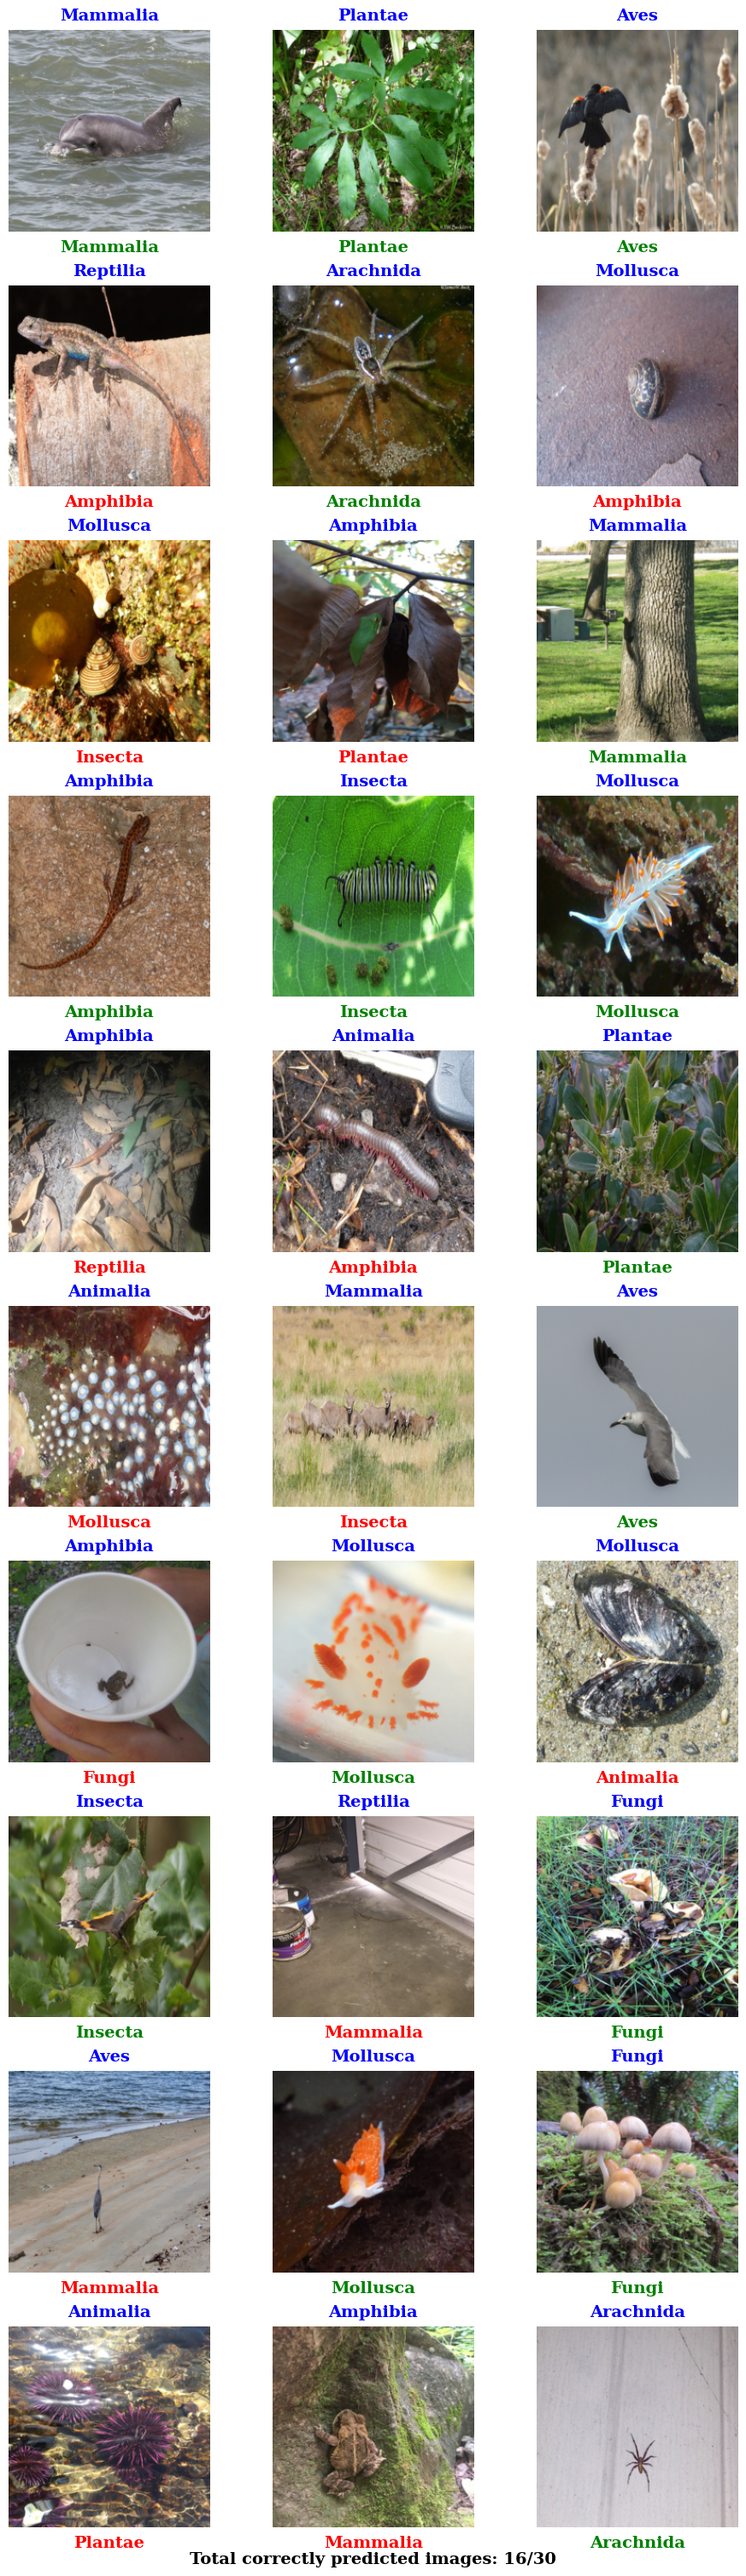

In [18]:
plot_grid(mt, device)